In [25]:
import sys
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sentence_transformers import SentenceTransformer
from torchvision import transforms, models

from datasets import load_dataset

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.inspection import DecisionBoundaryDisplay
from itertools import product


In [40]:
dataset = load_dataset("anson-huang/mirage-news")
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['image', 'label', 'text'],
        num_rows: 10000
    })
    validation: Dataset({
        features: ['image', 'label', 'text'],
        num_rows: 2500
    })
    test1_nyt_mj: Dataset({
        features: ['image', 'label', 'text'],
        num_rows: 500
    })
    test2_bbc_dalle: Dataset({
        features: ['image', 'label', 'text'],
        num_rows: 500
    })
    test3_cnn_dalle: Dataset({
        features: ['image', 'label', 'text'],
        num_rows: 500
    })
    test4_bbc_sdxl: Dataset({
        features: ['image', 'label', 'text'],
        num_rows: 500
    })
    test5_cnn_sdxl: Dataset({
        features: ['image', 'label', 'text'],
        num_rows: 500
    })
})


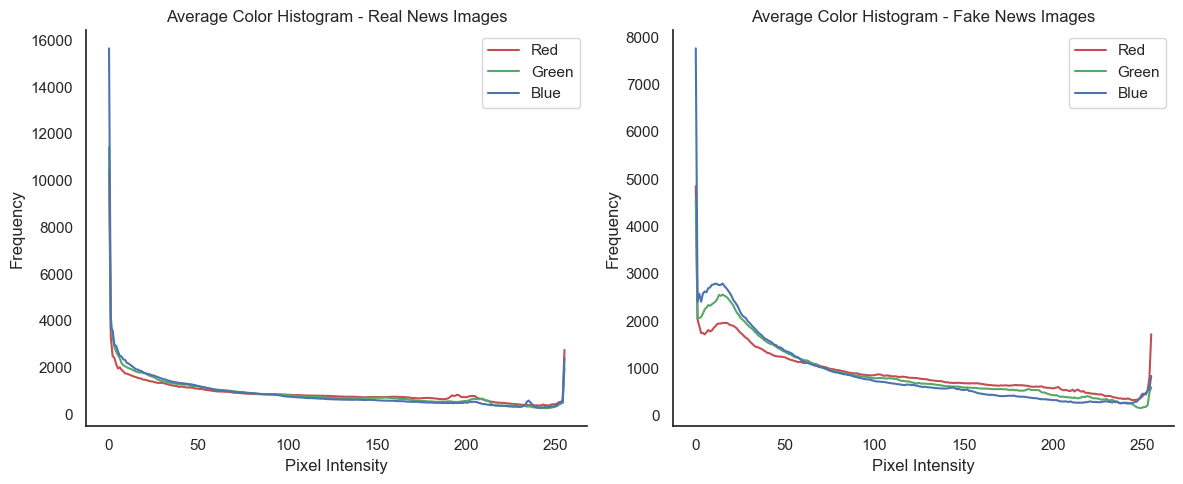

In [31]:
#plot of color channel intensities
sns.set(style="white", rc={"axes.grid": False})

bins = range(256)
plt.figure(figsize=(12, 5))

#real news
plt.subplot(1, 2, 1)
sns.lineplot(x=bins, y=real_r, color='r', label='Red')
sns.lineplot(x=bins, y=real_g, color='g', label='Green')
sns.lineplot(x=bins, y=real_b, color='b', label='Blue')
plt.title("Average Color Histogram - Real News Images")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.legend()
sns.despine()

#fake news
plt.subplot(1, 2, 2)
sns.lineplot(x=bins, y=fake_r, color='r', label='Red')
sns.lineplot(x=bins, y=fake_g, color='g', label='Green')
sns.lineplot(x=bins, y=fake_b, color='b', label='Blue')
plt.title("Average Color Histogram - Fake News Images")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.legend()
sns.despine()

plt.tight_layout()
plt.show()


In [5]:
####TEXT MODEL
text_train = [item["text"] for item in dataset["train"]]
text_val = [item["text"] for item in dataset["validation"]]

labels_train = torch.tensor([item["label"] for item in dataset["train"]], dtype=torch.long)
labels_val= torch.tensor([item["label"] for item in dataset["validation"]], dtype=torch.long)


In [6]:
text_model= SentenceTransformer("all-MiniLM-L6-v2")

#Convert text to embeddings
text_embeddings_train = text_model.encode(text_train, convert_to_tensor=True)
text_embeddings_val = text_model.encode(text_val, convert_to_tensor=True)

#Save tensors
torch.save(text_embeddings_train, "train_text.pt")
torch.save(text_embeddings_val, "val_text.pt")
torch.save(labels_train, "train_labels.pt")
torch.save(labels_val, "val_labels.pt")


In [7]:
X_train = torch.load("train_text.pt").cpu().numpy()
y_train = torch.load("train_labels.pt").cpu().numpy()
X_val = torch.load("val_text.pt").cpu().numpy()
y_val = torch.load("val_labels.pt").numpy()


In [9]:
#### Logistic Regression

X_train= X_train.reshape(X_train.shape[0], -1)
X_val = X_val.reshape(X_val.shape[0], -1)

text_lr = LogisticRegression(solver="lbfgs", max_iter=1000)
text_lr.fit(X_train, y_train)

y_pred = text_lr.predict(X_val)

print("Classification Report:")
print(classification_report(y_val, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.82      0.79      1250
           1       0.81      0.75      0.78      1250

    accuracy                           0.79      2500
   macro avg       0.79      0.79      0.79      2500
weighted avg       0.79      0.79      0.79      2500



In [10]:

#hp tuning 
param_grid = {"C": [0.001, 0.01, 0.1, 1,5, 10, 100]}
grid_search = GridSearchCV(text_lr, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
grid_search.fit(X_train, y_train)

best_c = grid_search.best_params_["C"]
print(f"Best hyperparameter (C): {best_c}")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Best hyperparameter (C): 10


In [11]:
test_datasets = ["test1_nyt_mj", "test2_bbc_dalle", "test3_cnn_dalle", "test4_bbc_sdxl"]

test_text_embeddings = {}
test_labels = {}

for test_set in test_datasets:
    text_tensors_test = [item["text"] for item in dataset[test_set]]
    labels_test = torch.tensor([item["label"] for item in dataset[test_set]], dtype=torch.long)
    text_embeddings_test = text_model.encode(text_tensors_test, convert_to_tensor=True)


    test_text_embeddings[test_set] = text_embeddings_test.cpu().numpy()
    test_labels[test_set] = labels_test.cpu().numpy()

In [12]:
final_model = LogisticRegression(C=10, max_iter=1000)
final_model.fit(X_train, y_train)

LogisticRegression(C=10, max_iter=1000)

In [13]:
#evaluation normal logreg
for test_set in test_datasets:
    X_test = test_text_embeddings[test_set]
    y_test = test_labels[test_set]

    X_test = X_test.reshape(X_test.shape[0], -1)

    y_pred = final_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    print(f"Test Set: {test_set}")
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("-" * 50)


Test Set: test1_nyt_mj
Accuracy: 0.8380
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.80      0.83       250
           1       0.81      0.88      0.84       250

    accuracy                           0.84       500
   macro avg       0.84      0.84      0.84       500
weighted avg       0.84      0.84      0.84       500

--------------------------------------------------
Test Set: test2_bbc_dalle
Accuracy: 0.7120
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.52      0.64       250
           1       0.65      0.91      0.76       250

    accuracy                           0.71       500
   macro avg       0.75      0.71      0.70       500
weighted avg       0.75      0.71      0.70       500

--------------------------------------------------
Test Set: test3_cnn_dalle
Accuracy: 0.7300
Classification Report:
              precision    recall  f1-score   sup

In [14]:
#logistic regression model with threshold tuning 
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

threshold = 0.7

for test_set in test_datasets:
    X_test = test_text_embeddings[test_set]
    y_test = test_labels[test_set]
    
    X_test = X_test.reshape(X_test.shape[0], -1)

    probs = logreg.predict_proba(X_test)[:, 1]

    #Applying custom threshold
    y_pred = (probs >= threshold).astype(int)

    accuracy = accuracy_score(y_test, y_pred)

    print(f"Test Set: {test_set}")
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("-" * 50)


Test Set: test1_nyt_mj
Accuracy: 0.8400
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.95      0.86       250
           1       0.94      0.73      0.82       250

    accuracy                           0.84       500
   macro avg       0.86      0.84      0.84       500
weighted avg       0.86      0.84      0.84       500

--------------------------------------------------
Test Set: test2_bbc_dalle
Accuracy: 0.7580
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.74      0.75       250
           1       0.75      0.78      0.76       250

    accuracy                           0.76       500
   macro avg       0.76      0.76      0.76       500
weighted avg       0.76      0.76      0.76       500

--------------------------------------------------
Test Set: test3_cnn_dalle
Accuracy: 0.7520
Classification Report:
              precision    recall  f1-score   sup

In [15]:
threshold_05 = 0.5
fpr, tpr, roc_thresholds = roc_curve(y_test, probs)

index_05 = np.argmin(np.abs(roc_thresholds - threshold_05))
fpr_05 = fpr[index_05 + 1]
tpr_05 = tpr[index_05 + 1]

plt.figure(figsize=(6, 6))
roc_color = '#1f77b4'  

# ROC curve
sns.set(style="white")
sns.lineplot(x=fpr, y=tpr, label='ROC Curve', linewidth=1, color=roc_color, ci=None)

plt.scatter(fpr_point, tpr_point, color='red', s=50, zorder=5, label='Threshold = 0.7')

plt.scatter(fpr_05, tpr_05, color=roc_color, s=50, zorder=5, label='Threshold = 0.5')
sns.despine()
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend()
plt.tight_layout()
plt.show()


NameError: name 'roc_thresholds' is not defined

Random Real News Example:
Label: Real
Headline: Doug Alcorn, who has worked for the federal Fish and Wildlife Service since 1985, cleaning out his office in Anchorage as he prepared to retire.



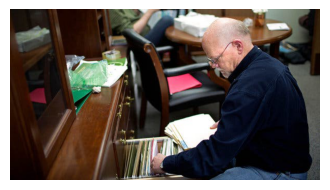

Random Fake News Example:


In [43]:
#Fake vs real image examples

def display_random_example(dataset, label, figsize=(4, 4)):
    filtered_items = [item for item in dataset if item["label"] == label]
    

    item = random.choice(filtered_items)
    image = item["image"]
    text = item["text"]

    print(f"Label: {'Real' if label == 0 else 'Fake'}")
    print(f"Headline: {text}\n")
    plt.figure(figsize=figsize)
    plt.imshow(image)
    plt.axis("off")  
    plt.show()

# random fake news example
print("Random Real News Example:")
display_random_example(dataset["train"], label=0)

#real news example
print("Random Fake News Example:")
display_random_example(dataset["train"], label=1)




In [16]:

# Image transformation (convert grayscale to 3-channel RGB)
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Lambda(lambda img: img.convert("RGB")),  
    transforms.ToTensor()
])

image_tensors_train = torch.stack([transform(item["image"]) for item in dataset["train"]])
image_tensors_val = torch.stack([transform(item["image"]) for item in dataset["validation"]])

torch.save(image_tensors_train,"image_train.pt")
torch.save(image_tensors_val, "image_val.pt")

labels_train = torch.load("train_labels.pt")
labels_val = torch.load("val_labels.pt")

train_dataset = TensorDataset(image_tensors_train, labels_train)
val_dataset = TensorDataset(image_tensors_val, labels_val)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)



In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import torch.nn.functional as F

class ImageClassifier(nn.Module):
    def __init__(self):
        super(ImageClassifier, self).__init__()
        self.model = models.resnet18(pretrained=True)
        
        num_features = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Dropout(0.5),  
            nn.Linear(num_features, 2)
        )

    def forward(self, x):
        return self.model(x)

image_model = ImageClassifier().to(device)



In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(image_model.parameters(), lr=0.00005)


In [21]:

num_epochs = 4

for epoch in range(num_epochs):
    image_model.train()
    running_loss= 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = image_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss:.4f}, Train Accuracy: {train_acc:.4f}")

print("Training complete.")


KeyboardInterrupt: 

In [23]:
image_model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = image_model(images)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

val_acc = correct / total
print(f"Validation Accuracy: {val_acc:.4f}")



Validation Accuracy: 0.7924


In [28]:

learning_rates = [0.0001, 0.00005]
batch_sizes = [32, 64]
dropout_rates = [0.3, 0.5]

param_grid = list(product(learning_rates, batch_sizes, dropout_rates))

best_val_acc = 0
best_params = None
for lr, batch_size, dropout in param_grid:
    print(f"Testing: lr={lr}, batch_size={batch_size}, dropout={dropout}")
    
    #dropout
    class ImageClassifier(nn.Module):
        def __init__(self):
            super(ImageClassifier, self).__init__()
            self.model = models.resnet18(pretrained=True)
            num_features = self.model.fc.in_features
            self.model.fc = nn.Sequential(
                nn.Dropout(dropout),
                nn.Linear(num_features, 2)
            )
    
        def forward(self, x):
            return self.model(x)

    image_model = ImageClassifier().to(device)
    
    optimizer= optim.Adam(image_model.parameters(), lr=lr)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    #5 epochs
    for epoch in range(5):
        image_model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = image_model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    image_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = image_model(images)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

    val_acc = correct / total
    print(f"Validation Accuracy: {val_acc:.4f}")

    #best params
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_params = (lr, batch_size, dropout)

print(f"Best Hyperparameters: lr={best_params[0]}, batch_size={best_params[1]}, dropout={best_params[2]}")


Testing: lr=0.0001, batch_size=32, dropout=0.3
Validation Accuracy: 0.8308
Testing: lr=0.0001, batch_size=32, dropout=0.5
Validation Accuracy: 0.8232
Testing: lr=0.0001, batch_size=64, dropout=0.3
Validation Accuracy: 0.8396
Testing: lr=0.0001, batch_size=64, dropout=0.5
Validation Accuracy: 0.8376
Testing: lr=5e-05, batch_size=32, dropout=0.3
Validation Accuracy: 0.8372
Testing: lr=5e-05, batch_size=32, dropout=0.5
Validation Accuracy: 0.8408
Testing: lr=5e-05, batch_size=64, dropout=0.3
Validation Accuracy: 0.8348
Testing: lr=5e-05, batch_size=64, dropout=0.5
Validation Accuracy: 0.8268
Best Hyperparameters: lr=5e-05, batch_size=32, dropout=0.5


In [25]:
torch.save(image_model.state_dict(), "image_model.pth")


Model saved successfully!


In [36]:

#Processing test sets

for test_set in test_datasets:
    print(f"Processing {test_set}...")
    
    #transformations
    image_tensors_test = torch.stack([process_image(item["image"]) for item in dataset[test_set]])
    labels_test = torch.tensor([item["label"] for item in dataset[test_set]], dtype=torch.long)
    
  
    torch.save(image_tensors_test, f"{test_set}_images.pt")
    torch.save(labels_test, f"{test_set}_labels.pt")



Processing test1_nyt_mj...
Processing test2_bbc_dalle...
Processing test3_cnn_dalle...
Processing test4_bbc_sdxl...
Test images processed and saved successfully!


In [40]:
#test data and evaluate
test_datasets = ["test1_nyt_mj", "test2_bbc_dalle", "test3_cnn_dalle", "test4_bbc_sdxl"]
test_results = {}

for test_set in test_datasets:
    images_test = torch.load(f"{test_set}_images.pt")
    labels_test = torch.load(f"{test_set}_labels.pt")

    images_test = images_test.to(device)
    
    with torch.no_grad():
        outputs = image_model(images_test)
        _, predicted = outputs.max(1)

    y_true = labels_test.cpu().numpy()
    y_pred = predicted.cpu().numpy()

  
    test_results[test_set] = {"y_true": y_true, "y_pred": y_pred}

    print(f"Test Set: {test_set}")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print("Classification Report:")
    print(classification_report(y_true, y_pred))
    print("-" * 50)


Test Set: test1_nyt_mj
Accuracy: 0.8120
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.82      0.81       250
           1       0.82      0.80      0.81       250

    accuracy                           0.81       500
   macro avg       0.81      0.81      0.81       500
weighted avg       0.81      0.81      0.81       500

--------------------------------------------------
Test Set: test2_bbc_dalle
Accuracy: 0.5080
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.86      0.64       250
           1       0.53      0.16      0.25       250

    accuracy                           0.51       500
   macro avg       0.52      0.51      0.44       500
weighted avg       0.52      0.51      0.44       500

--------------------------------------------------
Test Set: test3_cnn_dalle
Accuracy: 0.5160
Classification Report:
              precision    recall  f1-score   sup

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from torch.utils.data import DataLoader, TensorDataset

# Load saved embeddings
text_train = torch.load("train_text.pt")  # [N, D_text]
image_train = torch.load("image_train.pt")  # [N, 3, 64, 64]
text_val = torch.load("val_text.pt")
image_val = torch.load("image_val.pt")
labels_train = torch.load("train_labels.pt")
labels_val = torch.load("val_labels.pt")

# Load pretrained ResNet for feature extraction
resnet = models.resnet18(pretrained=True)
resnet.fc = nn.Identity()  # remove final classifier
resnet.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet.to(device)

# Feature extraction function
def extract_image_features(images, batch_size=32):
    dataloader = DataLoader(TensorDataset(images), batch_size=batch_size)
    features = []

    with torch.no_grad():
        for batch in dataloader:
            imgs = batch[0].to(device)
            feats = resnet(imgs)
            features.append(feats.cpu())

    return torch.cat(features, dim=0)

# Extract image features
image_feats_train = extract_image_features(image_train)
image_feats_val = extract_image_features(image_val)

# Combine text and image features
X_train_combined = torch.cat([text_train.cpu(), image_feats_train], dim=1).numpy()
X_val_combined = torch.cat([text_val.cpu(), image_feats_val], dim=1).numpy()
y_train_np = labels_train.numpy()
y_val_np = labels_val.numpy()

# Train logistic regression on combined features
fusion_model = LogisticRegression(max_iter=1000)
fusion_model.fit(X_train_combined, y_train_np)

# Evaluate
y_pred = fusion_model.predict(X_val_combined)
print("Validation Accuracy (Fusion Model):", accuracy_score(y_val_np, y_pred))
print("Classification Report:")
print(classification_report(y_val_np, y_pred))


FileNotFoundError: [Errno 2] No such file or directory: 'train_text.pt'